# Description:

    A quick and dirty ordination of all OTUs



# Setting variables

In [11]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/ord_raw/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [12]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [13]:
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [14]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)

In [15]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [16]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 68K
lrwxrwxrwx 1 bryan bryan  130 Feb 10 17:09 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan  143 Feb 10 17:09 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 9.6K Nov 20 09:15 NMDS_DAPfacet.pdf
-rw-rw-r-- 1 bryan bryan 7.4K Nov 10 06:58 NMDS_full_wunif.pdf
-rw-rw-r-- 1 bryan bryan 7.9K Nov  9 13:18 NMDS_plant_wunif.pdf
-rw-rw-r-- 1 bryan bryan 8.0K Aug 11  2015 facet_NMDS_w-enz.pdf
-rw-rw-r-- 1 bryan bryan  22K Jul 27  2015 heatmap_rank2.pdf


# Loading/editting OTU table

In [17]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [18]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))

print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 240 samples ]
sample_data() Sample Data:       [ 240 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


## Normalize samples and filter out taxa that are less than 3seq in 3 samples 

In [19]:
%%R 
# filtering/normalizing
physeq.p = prune_samples(sampleSums(physeq) >= 10, physeq)

PassFilter = 
filter_taxa(physeq, 
             function(x) sum(x > 3) > 3, TRUE) %>%
                 taxa_names()

physeq.snorm = transform_sample_counts(physeq.p, function(x) x/sum(x))

physeq.snorm = prune_taxa(PassFilter, physeq)  
    


## Calculate pairwise weighted Unifrac distances between samples

In [20]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-Unifrac

Run 0 stress 0.1406112 
Run 1 stress 0.1746141 
Run 2 stress 0.1504606 
Run 3 stress 0.1438358 
Run 4 stress 0.1434498 
Run 5 stress 0.1827414 
Run 6 stress 0.1842773 
Run 7 stress 0.1801904 
Run 8 stress 0.1435123 
Run 9 stress 0.1693511 
Run 10 stress 0.1871159 
Run 11 stress 0.1448211 
Run 12 stress 0.1429936 
Run 13 stress 0.1648964 
Run 14 stress 0.1526279 
Run 15 stress 0.1734644 
Run 16 stress 0.174152 
Run 17 stress 0.1783522 
Run 18 stress 0.1644989 
Run 19 stress 0.1600539 
Run 20 stress 0.1429885 


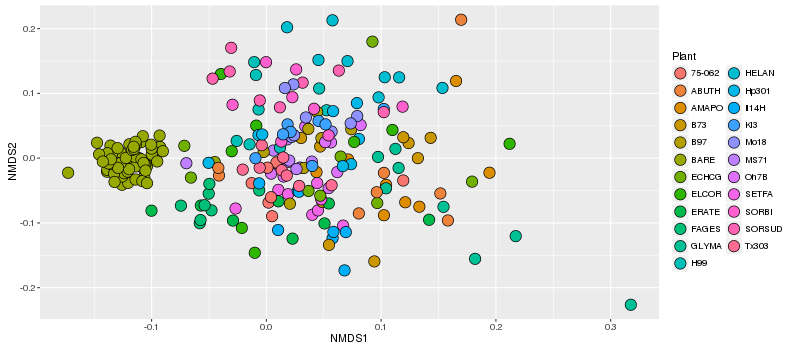

In [21]:
%%R -w 800 -h 350

nmds = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = wunif.dist)

p = plot_ordination(physeq.snorm, nmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21, size = 5) +
        guides(fill=guide_legend(ncol=2))
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Saving 12.5 x 8.33 in image

  res = super(Function, self).__call__(*new_args, **new_kwargs)


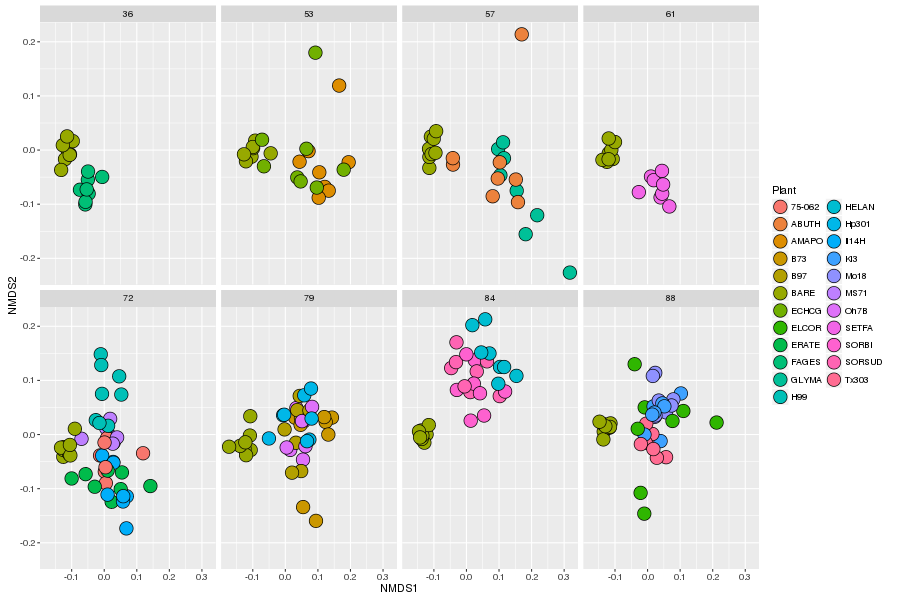

In [22]:
%%R -w 900 -h 600


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) +
        facet_wrap(~ DAP, nrow = 2) +
        guides(fill=guide_legend(ncol=2))
        

p1 %>% print
ggsave(filename = "NMDS_DAPfacet.pdf", plot = p1)

## Subset just bare soils to analyze change with time

In [23]:
%%R

bare = subset_samples(physeq.snorm, Plant == "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)


In [24]:
%%R
registerDoParallel(cores=28)
bare.wunif.dist = distance(bare, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [25]:
%%R -w 800 -h 350


nmds = ordinate(bare, 
                method = "NMDS", 
               distance = bare.wunif.dist)

p = plot_ordination(bare, nmds, justDF = TRUE)

Run 0 stress 0.1542615 
Run 1 stress 0.1925842 
Run 2 stress 0.1542616 
... procrustes: rmse 2.104018e-05  max resid 9.306498e-05 
*** Solution reached


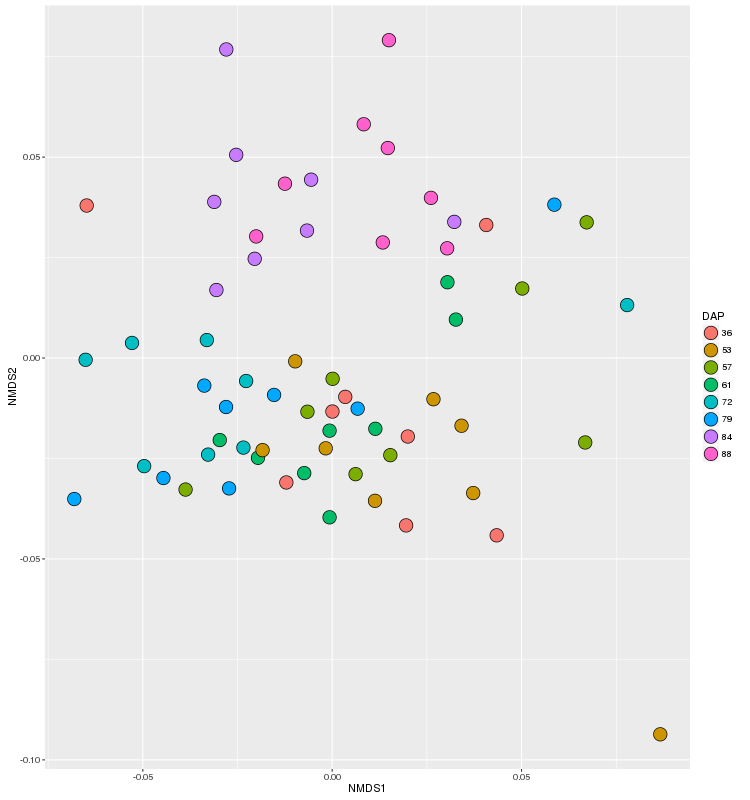

In [26]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=DAP), size = 6, pch=21) 

p1

In [27]:
%%R
df = as(sample_data(bare), "data.frame")
d = bare.wunif.dist
bareadonis = adonis(d ~ DAP + Rep + Library, df)
bareadonis


Call:
adonis(formula = d ~ DAP + Rep + Library, data = df) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
DAP        7   0.09271 0.013244  3.7696 0.28372  0.001 ***
Rep        1   0.00795 0.007948  2.2622 0.02432  0.030 *  
Library    1   0.03638 0.036379 10.3545 0.11133  0.001 ***
Residuals 54   0.18972 0.003513         0.58062           
Total     63   0.32676                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [28]:
%%R
df = as(sample_data(bare), "data.frame")
d = bare.bray.dist
bareadonis = adonis(d ~ DAP + Rep + Library, df)
bareadonis



Error in withVisible({ : object 'bare.bray.dist' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'bare.bray.dist' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/o

## Cluster analysis to determine if Mi-Seq Run is grouping

In [29]:
%%R
HC = hclust(bare.wunif.dist, method = "average", members = NULL)

$type
[1] "phylogram"

$use.edge.length
[1] TRUE

$node.pos
[1] 1

$node.depth
[1] 1

$show.tip.label
[1] TRUE

$show.node.label
[1] FALSE

$font
[1] 3

$cex
[1] 1

$adj
[1] 0

$srt
[1] 0

$no.margin
[1] FALSE

$label.offset
[1] 0

$x.lim
[1] 0.0000000 0.1100386

$y.lim
[1]  1 64

$direction
[1] "rightwards"

$tip.color
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[39] 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

$Ntip
[1] 64

$Nnode
[1] 63

$root.time
NULL

$align.tip.label
[1] FALSE



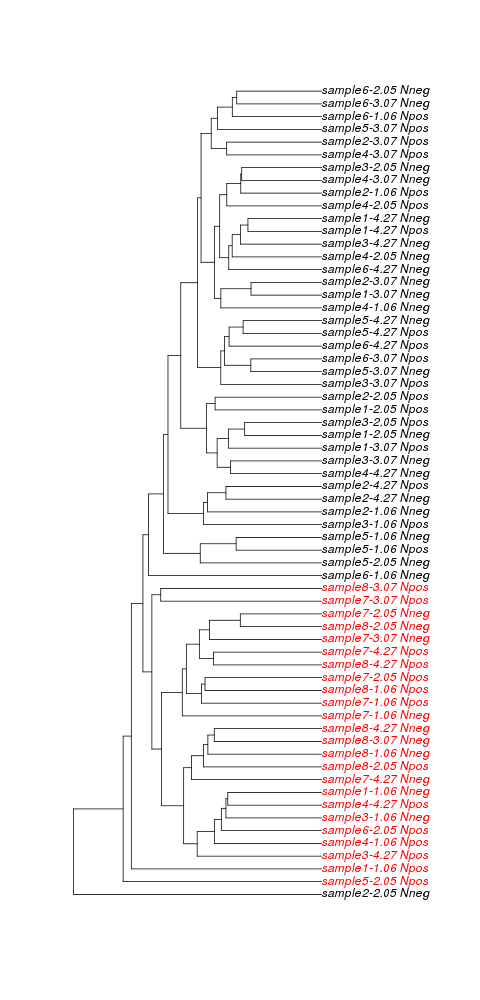

In [30]:
%%R -h 1000
library(ape)
Var = sample_data(bare)$Library   # factor variable for colors
result_phylo <- as.phylo(HC)
p = plot(result_phylo, tip.col = as.numeric(as.character(Var)))
p

In [31]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/diagnostics/control_batch.pdf", width = 6.5, height = 9)
p = plot(result_phylo, tip.col = Var)
dev.off()

png 
  2 


In [32]:
%%R
colnames(sample_data(bare))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        


In [33]:
%%R
sample_data(bare)[,1:7]

Sample Data:        [64 samples by 7 sample variables]:
                           X.sample Library Primer_Plate Primer_Well_ID
sample2-1.06_Npos sample2-1.06_Npos       1            1             H9
sample6-4.27_Npos sample6-4.27_Npos       1            2            F11
sample4-4.27_Nneg sample4-4.27_Nneg       1            1            B12
sample4-1.06_Nneg sample4-1.06_Nneg       1            1            E11
sample2-1.06_Nneg sample2-1.06_Nneg       1            1             G9
sample6-3.07_Nneg sample6-3.07_Nneg       1            2            C11
sample5-3.07_Nneg sample5-3.07_Nneg       1            2             D9
sample6-3.07_Npos sample6-3.07_Npos       1            2            D11
sample3-3.07_Npos sample3-3.07_Npos       1            1            C11
sample1-4.27_Npos sample1-4.27_Npos       1            1             F9
sample4-3.07_Nneg sample4-3.07_Nneg       1            1            H11
sample6-1.06_Npos sample6-1.06_Npos       1            2            A11
sample4-

In [34]:
%%R
registerDoParallel(cores=28)
bare.bray.dist = distance(bare, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [35]:
%%R
HC = hclust(bare.bray.dist, method = "average", members = NULL)

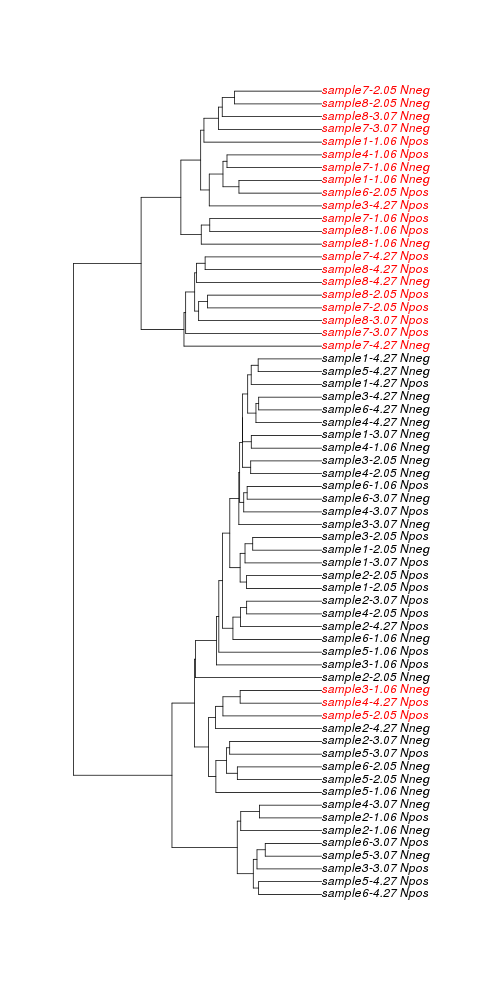

In [36]:
%%R -h 1000
library(ape)
Var = sample_data(bare)$Library   # factor variable for colors
result_phylo <- as.phylo(HC)
plot(result_phylo, tip.col = Var)

## Subset just plants to evaluate variation without bare soil

In [37]:
%%R

plant = subset_samples(physeq.snorm, Plant != "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)
plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4986 taxa and 176 samples ]
sample_data() Sample Data:       [ 176 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 4986 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4986 tips and 4985 internal nodes ]


In [38]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = distance(plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [39]:
%%R -w 800 -h 350


nmds = ordinate(plant, 
                method = "NMDS", 
               distance = wunif.dist)

p = plot_ordination(plant, nmds, justDF = TRUE)

Run 0 stress 0.1406112 
Run 1 stress 0.1748121 
Run 2 stress 0.1732517 
Run 3 stress 0.1527042 
Run 4 stress 0.1723468 
Run 5 stress 0.1608843 
Run 6 stress 0.1643865 
Run 7 stress 0.2008157 
Run 8 stress 0.193438 
Run 9 stress 0.1555662 
Run 10 stress 0.1545374 
Run 11 stress 0.1541702 
Run 12 stress 0.1517874 
Run 13 stress 0.4173846 
Run 14 stress 0.142294 
Run 15 stress 0.153112 
Run 16 stress 0.1562881 
Run 17 stress 0.1459956 
Run 18 stress 0.1497649 
Run 19 stress 0.1411101 
... procrustes: rmse 0.007367781  max resid 0.1058385 
Run 20 stress 0.1694744 


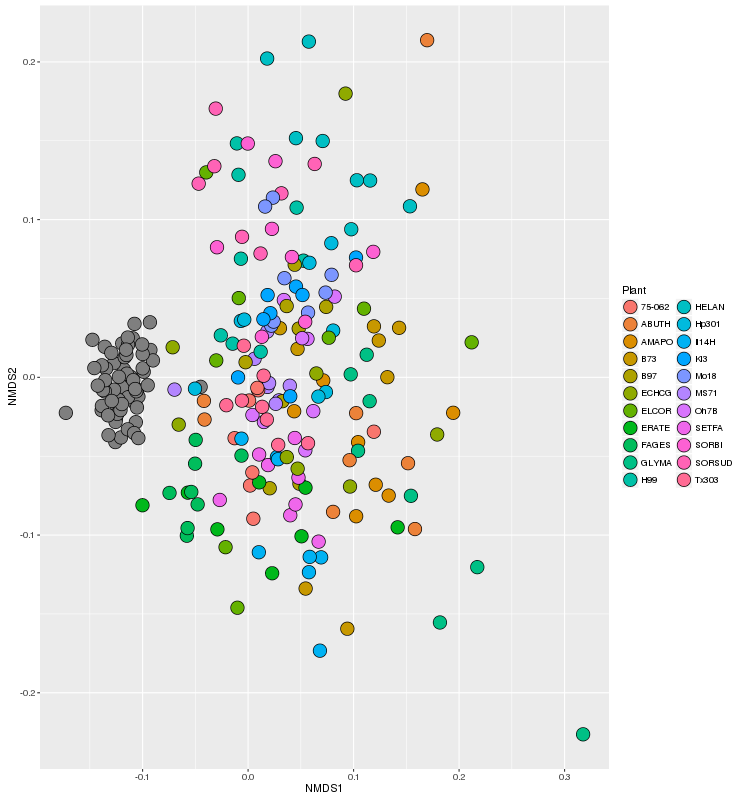

In [40]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

In [41]:
%%R
registerDoParallel(cores=28)
plant.bray.dist = distance(plant, 
                      method = "bray", 
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [42]:
%%R
HC = hclust(plant.bray.dist, method = "average", members = NULL)

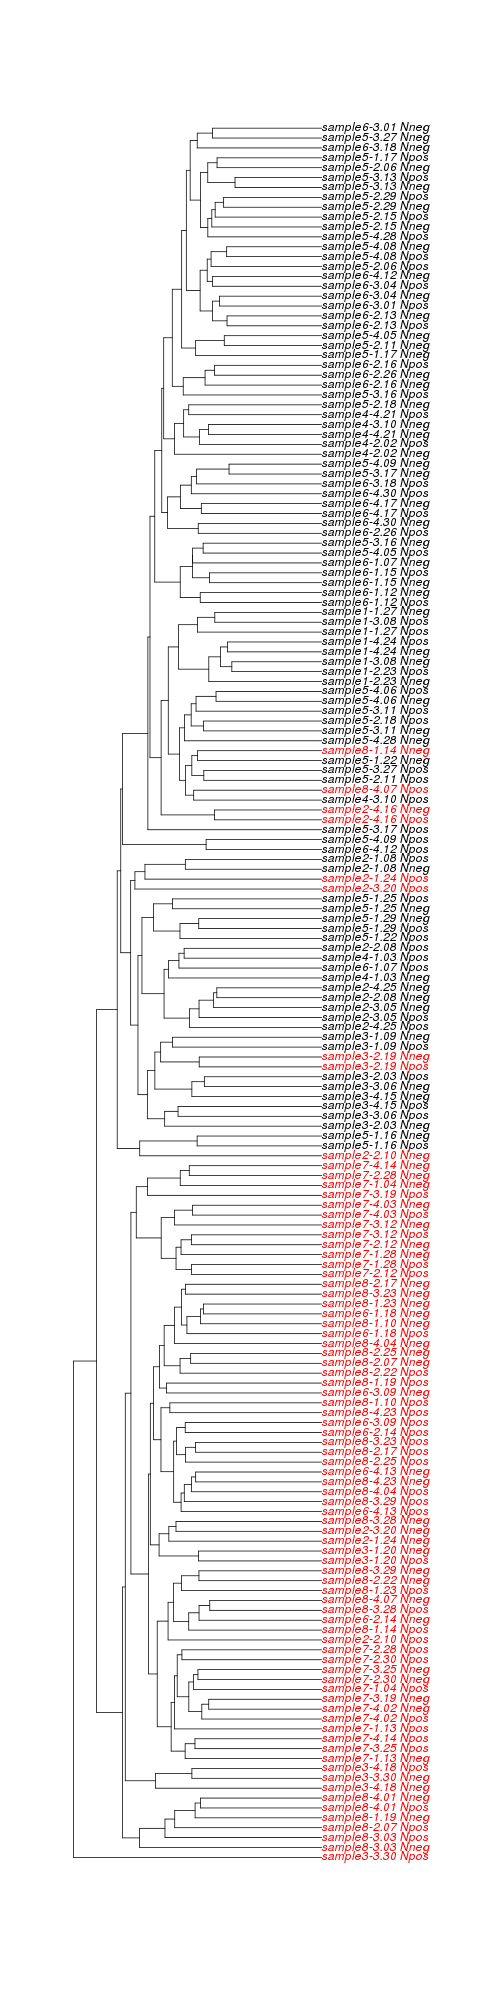

In [43]:
%%R -h 2000
library(ape)
Var = sample_data(plant)$Library   # factor variable for colors
result_phylo <- as.phylo(HC)
plot(result_phylo, tip.col = Var)

##Hypothesis Testing on Plant subset

In [44]:
%%R
df = as(sample_data(plant), "data.frame")
d = wunif.dist
plantadonis = adonis(d ~ DAP + Plant, df)
plantadonis


Error in G * t(hat) : non-conformable arrays


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in G * t(hat) : non-conformable arrays

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [45]:
%%R
plant_group = get_variable(plant, "Plant")
d = wunif.dist
ano1 = anosim(d, plant_group)
summary(ano1)


Error in cl.vec[within] <- levels(grouping)[grouping[take]] : 
  NAs are not allowed in subscripted assignments


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in cl.vec[within] <- levels(grouping)[grouping[take]] : 
  NAs are not allowed in subscripted assignments

  res = super(Function, self).__call__(*new_args, **new_kwargs)


## NMDS of unweighted-unifrac distances

In [46]:
%%R
registerDoParallel(cores=28)

uwunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.1527069 
Run 1 stress 0.1655409 
Run 2 stress 0.1550125 
Run 3 stress 0.1550031 
Run 4 stress 0.1577322 
Run 5 stress 0.1580608 
Run 6 stress 0.1526927 
... New best solution
... procrustes: rmse 0.003132143  max resid 0.02086909 
Run 7 stress 0.1761908 
Run 8 stress 0.1863556 
Run 9 stress 0.1821805 
Run 10 stress 0.1802187 
Run 11 stress 0.1580948 
Run 12 stress 0.1643116 
Run 13 stress 0.155024 
Run 14 stress 0.1794263 
Run 15 stress 0.1634511 
Run 16 stress 0.1638279 
Run 17 stress 0.1646379 
Run 18 stress 0.1825191 
Run 19 stress 0.1580514 
Run 20 stress 0.1846073 


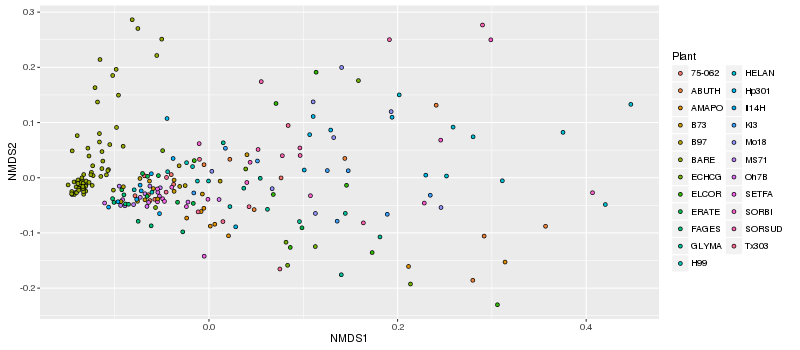

In [47]:
%%R -w 800 -h 350


nmds = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = uwunif.dist)

p = plot_ordination(physeq.snorm, nmds, justDF = TRUE)


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

#Heatmaps of taxon abundances



In [48]:
%%R
physeq.snorm %>% tax_table %>% head

Taxonomy Table:     [6 taxa by 8 taxonomic ranks]:
         Rank1      Rank2              Rank3                  
OTU.5899 "Bacteria" "__Acidobacteria"  "__32-21"              
OTU.8680 "Bacteria" "__Acidobacteria"  "__Holophagae"         
OTU.2666 "Bacteria" "__Acidobacteria"  "__Holophagae"         
OTU.323  "Bacteria" "__Acidobacteria"  "__Holophagae"         
OTU.7636 "Bacteria" "__Acidobacteria"  "__Holophagae"         
OTU.1030 "Bacteria" "__Proteobacteria" "__Deltaproteobacteria"
         Rank4                    Rank5                    Rank6          Rank7
OTU.5899 "__uncultured_bacterium" NA                       NA             NA   
OTU.8680 "__Sva0725"              NA                       NA             NA   
OTU.2666 "__Sva0725"              "__uncultured_bacterium" NA             NA   
OTU.323  "__Sva0725"              NA                       NA             NA   
OTU.7636 "__Sva0725"              NA                       NA             NA   
OTU.1030 "__Desulfobacterale

In [49]:
%%R -w 800 
physeq.snorm.t50 <- prune_taxa(names(sort(taxa_sums(physeq.snorm),TRUE)[1:10]), physeq.snorm)

plot_heatmap(physeq.snorm.t50, sample.label='Plant', taxa.label='Rank2')

ggsave("heatmap_rank2.pdf")

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Saving 11.1 x 6.67 in image

  res = super(Function, self).__call__(*new_args, **new_kwargs)


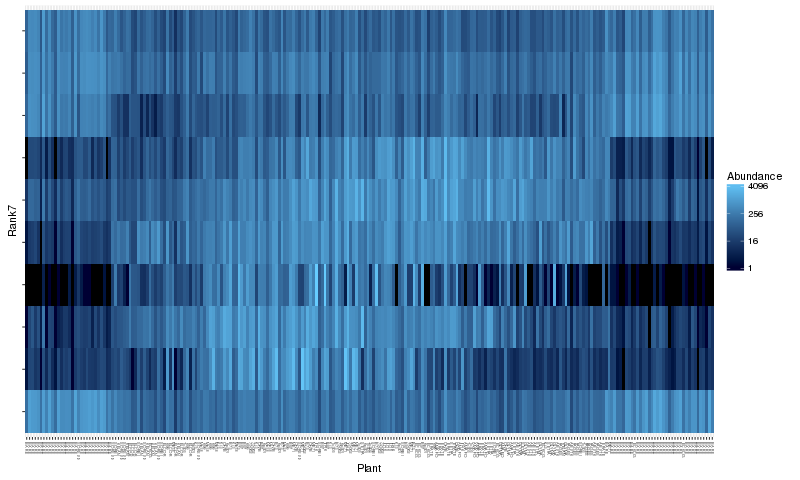

In [50]:
%%R -w 800 
physeq.snorm.t50 <- prune_taxa(names(sort(taxa_sums(physeq.snorm),TRUE)[1:10]), physeq.snorm)

plot_heatmap(physeq.snorm.t50, sample.label='Plant', taxa.label='Rank7')

##Analysis of changes in bare soil community over time

In [51]:
%%R
sample_names(physeq)

  [1] "sample2-1.06_Npos" "sample6-4.27_Npos" "sample4-4.27_Nneg"
  [4] "sample4-1.06_Nneg" "sample2-1.06_Nneg" "sample6-3.07_Nneg"
  [7] "sample5-3.07_Nneg" "sample6-3.07_Npos" "sample3-3.07_Npos"
 [10] "sample5-1.22_Nneg" "sample6-4.12_Npos" "sample1-4.27_Npos"
 [13] "sample4-1.03_Npos" "sample5-2.06_Npos" "sample5-4.08_Npos"
 [16] "sample4-3.07_Nneg" "sample5-4.28_Npos" "sample6-1.06_Npos"
 [19] "sample4-2.05_Nneg" "sample2-4.27_Nneg" "sample1-2.05_Nneg"
 [22] "sample5-1.29_Npos" "sample5-4.27_Npos" "sample5-4.27_Nneg"
 [25] "sample1-3.07_Nneg" "sample4-2.02_Nneg" "sample4-4.21_Nneg"
 [28] "sample2-2.05_Nneg" "sample6-2.13_Npos" "sample5-2.29_Nneg"
 [31] "sample5-2.06_Nneg" "sample1-2.23_Nneg" "sample6-2.26_Nneg"
 [34] "sample6-3.18_Nneg" "sample5-3.13_Nneg" "sample2-2.08_Nneg"
 [37] "sample1-2.05_Npos" "sample3-2.05_Nneg" "sample5-1.17_Nneg"
 [40] "sample6-3.01_Npos" "sample3-2.03_Nneg" "sample5-4.08_Nneg"
 [43] "sample5-4.05_Npos" "sample5-1.06_Npos" "sample1-4.27_Nneg"
 [46] "sam